<a href="https://www.kaggle.com/code/jeffreyesedo/1st-ribo-note?scriptVersionId=151222394" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [7]:
# Setting up an RNA Science Environment
!pip install arnie
!pip install draw_rna

# Install EternaFold
!conda config --set auto_update_conda false
!conda install -c bioconda eternafold --yes
# Manually setup EternaFold for Kaggle notebook
%env ETERNAFOLD_PATH=/opt/conda/bin/eternafold-bin
%env ETERNAFOLD_PARAMETERS=/opt/conda/lib/eternafold-lib/parameters/EternaFoldParams.v1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 9.2 MB/s eta 0:00:00
Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.3
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - eternafold


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    eternafold-1.3.1           |       h4ac6f70_0        17.6 MB  bioconda
    openssl-3.1.4              |       hd590300_0         2.5 MB  conda-forge
    ------------------------------------------------------------
                   

In [9]:
import os
import psutil
import gc
import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm as tq
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# monitor memeory usage
# def memory_usage_in_gb():
#     process = psutil.Process(os.getpid())
#     memory_use_in_bytes = process.memory_info().rss
#     memory_use_in_gb = memory_use_in_bytes / (2. ** 30)
#     return f'Memory usage: {np.round(memory_use_in_gb, 2)} GB'

In [10]:
from arnie.mfe import mfe
from arnie.bpps import bpps
from draw_rna.ipynb_draw import draw_struct

# Import Datasets

In [11]:
train= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/train_data.csv")
# train= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/train_data_QUICK_START.csv")

test= pd.read_csv("/kaggle/input/stanford-ribonanza-rna-folding/test_sequences.csv")

In [12]:
print(f"Train dataset shape: {train.shape}\n")

print(f"Test dataset shape: {test.shape}")

Train dataset shape: (1643680, 419)

Test dataset shape: (1343823, 5)


# Reduce Memory usage
Using the dataset as is consume a lot of memory and cause the codes to run slow and eventually crash, so there is need to import the in manner that reduces memory usage, improves speed, and retain the overall information of the original dataset.

In [13]:
# optimize numeric data types
def opt_num(df):
    df= df.copy()
    
    for col in df.columns:
        df_col= df[col]
        dn = df_col.dtype.name
        
        if dn == "int64":
            df[col]= pd.to_numeric(df_col, downcast="integer")
        elif dn == "float64":
            df[col]= pd.to_numeric(df_col, downcast="float")
        elif dn == "object":
            num_unique_values = len(df_col.unique())
            num_total_values = len(df_col)
            if num_unique_values / num_total_values < 0.5:
                df[col] = df_col.astype("category")
    return df

In [15]:
opt_train= opt_num(train)
opt_test= opt_num(test)

In [16]:
print(f"Train Dataset:{train.iloc[0:5, 0:10].info()}\n")
print(f"Optimized Dataset: {opt_train.iloc[0:5, 0:10].info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sequence_id      5 non-null      object 
 1   sequence         5 non-null      object 
 2   experiment_type  5 non-null      object 
 3   dataset_name     5 non-null      object 
 4   reads            5 non-null      int64  
 5   signal_to_noise  5 non-null      float64
 6   SN_filter        5 non-null      int64  
 7   reactivity_0001  0 non-null      float64
 8   reactivity_0002  0 non-null      float64
 9   reactivity_0003  0 non-null      float64
dtypes: float64(4), int64(2), object(4)
memory usage: 528.0+ bytes
Train Dataset:None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sequence_id      5 non-null      category
 1   sequence     

In [17]:
del train
del test
gc.collect()

480

In [34]:
# Export Dataset as Parquet
# opt_train.to_parquet('train_data.parquet')
# opt_test.to_parquet('test_data.parquet')

# Import Parquet Dataset
# train_df = pd.read_parquet('/kaggle/working/train_data.parquet')
# train_df.head()

In [11]:
opt_train.head()

,sequence_id,sequence,experiment_type,dataset_name,reads,signal_to_noise,SN_filter,reactivity_0001,reactivity_0002,reactivity_0003,...,reactivity_error_0197,reactivity_error_0198,reactivity_error_0199,reactivity_error_0200,reactivity_error_0201,reactivity_error_0202,reactivity_error_0203,reactivity_error_0204,reactivity_error_0205,reactivity_error_0206
0,8cdfeef009ea,GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,2343,0.944,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51e61fbde94d,GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,5326,1.933,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25ce8d5109cd,GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,4647,2.347,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07dcfb6d1965,GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,102843,11.824,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e561cc042a4c,GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...,2A3_MaP,15k_2A3,7665,3.519,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
print(f"Test Columns: {opt_test.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343823 entries, 0 to 1343822
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id_min       1343823 non-null  int32 
 1   id_max       1343823 non-null  int32 
 2   sequence_id  1343823 non-null  object
 3   sequence     1343823 non-null  object
 4   future       1343823 non-null  int8  
dtypes: int32(2), int8(1), object(2)
memory usage: 32.0+ MB
Test Columns: None


In [13]:
# Count columns based on their Dtype
dtype_counts = opt_train.dtypes.value_counts()
print(dtype_counts)

float32     413
category      1
category      1
category      1
category      1
int32         1
int8          1
Name: count, dtype: int64


In [14]:
experiments_count= opt_train["experiment_type"].value_counts()
print(experiments_count)

experiment_type
2A3_MaP    821840
DMS_MaP    821840
Name: count, dtype: int64


In [15]:
float_columns = opt_train.select_dtypes(include=['float'])
float_columns.columns

Index(['signal_to_noise', 'reactivity_0001', 'reactivity_0002',
       'reactivity_0003', 'reactivity_0004', 'reactivity_0005',
       'reactivity_0006', 'reactivity_0007', 'reactivity_0008',
       'reactivity_0009',
       ...
       'reactivity_error_0197', 'reactivity_error_0198',
       'reactivity_error_0199', 'reactivity_error_0200',
       'reactivity_error_0201', 'reactivity_error_0202',
       'reactivity_error_0203', 'reactivity_error_0204',
       'reactivity_error_0205', 'reactivity_error_0206'],
      dtype='object', length=413)

In [24]:
# Null values in reactivity and reactivity_error
# float_columns.info(verbose=True, show_counts=True)

# print(float_columns["reactivity_error_0043"].notna().sum())
# print(float_columns["reactivity_0043"].isna().sum())


1561976


In [23]:
# Columns that are NaN
num_empty_cols= 0
cols_having_values=0


# for col in float_columns.drop('signal_to_noise', axis=1):
for col in float_columns:
    if float_columns[col].notna().sum() == 0:
        num_empty_cols+=1
    else:
        cols_having_values+=1
        
print(f"Number of Columns with only NaN values: {num_empty_cols} of 412 columns\n")
print(f"Number of Columns with values: {cols_having_values} of 412 columns")

Number of Columns with only NaN values: 134 of 412 columns

Number of Columns with values: 279 of 412 columns


In [ ]:
for index, row in opt_train.iterrows():
    print(row["experiment_type"][0:5], row["sequence"][0:5])
    
        

In [25]:
for i in range(6):
    structure = mfe(opt_train.sequence[i],package="eternafold")
    experiment= opt_train.experiment_type[i]
    print(experiment,structure)

2A3_MaP .....((((((.....))))))......((((((..(((((((((((..(((((((.....(((((...((((....))))...))))))))))))....)..))))))))))...)))))).......((((((((....)))))))).....................
2A3_MaP .....((((((.....)))))).....(.(((((..(((((((((((..(((((((.....(((((...((((....))))...))))))))))))....)..))))))))))...)))))...)....((((((((....)))))))).....................
2A3_MaP ((...((((((.....)))))).....))(((((..(((((((((((..(((((((.....(((((...((((....))))...))))))))))))....)..))))))))))...)))))........((((((((....)))))))).....................
2A3_MaP .....((((((.....)))))).......(((((..(((((((((((..(((((((.....(((((...((((....))))...))))))))))))....)..))))))))))...)))))........((((((((....)))))))).....................
2A3_MaP .....((((((.....))))))........((((..(((((((((((..(((((((.....(((((...((((....))))...))))))))))))....)..))))))))))...)))).........((((((((....)))))))).....................
2A3_MaP .....((((((.....))))))......(.((((..(((((((((((..(((((((.....(((((...((((....))))...)))))))))))).

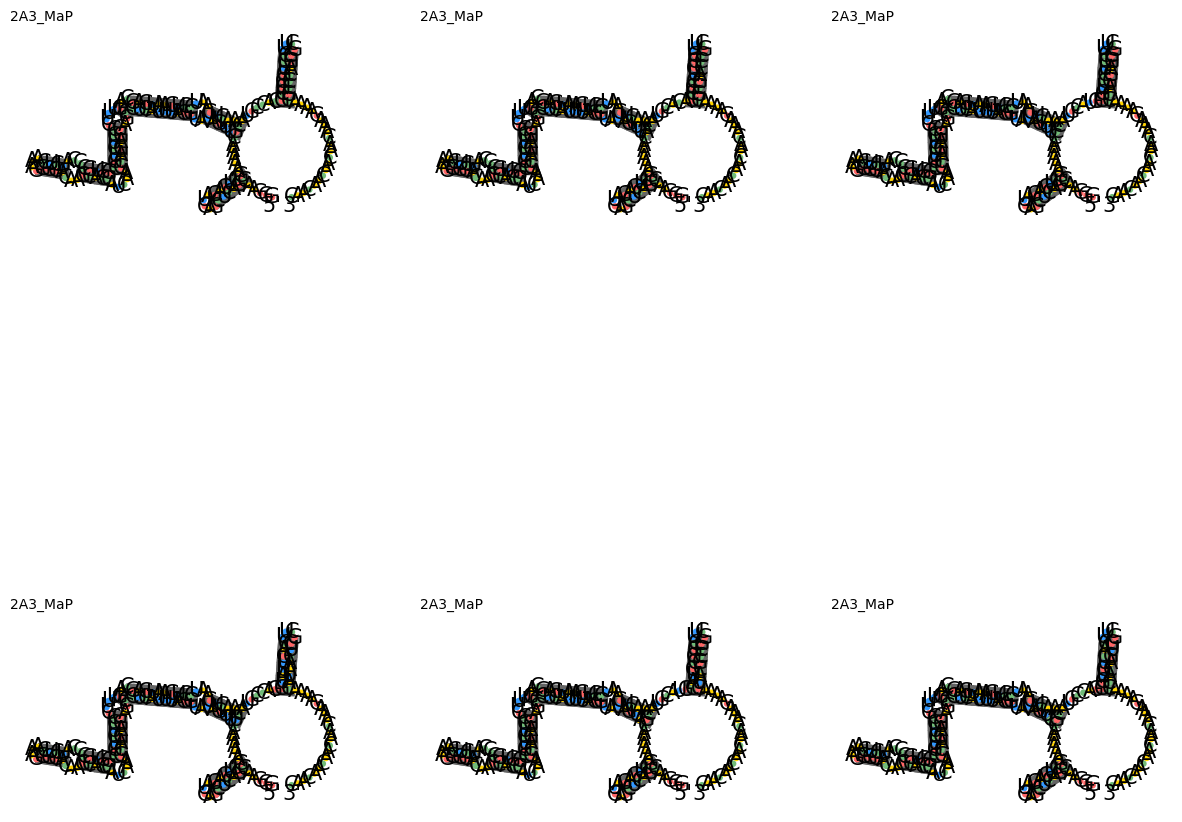

In [26]:
# Veiwing the first six sequences
fig, axs = plt.subplots(2, 3, figsize=(15,14))

for i in range(6):
    ax = axs[i//3, i%3]  # Get the current axes
    draw_struct(opt_train.sequence[i], structure, ax=ax)  # Draw the structure on the current axes
    ax.set_title(opt_train.experiment_type[i], loc='left', fontsize='medium')

plt.show()

In [44]:
len_seq = pd.Series([len(t) for t in opt_train['sequence']])
len_seq.value_counts()

177    294788
170     27254
115      5154
206      4768
155      3652
Name: count, dtype: int64

lengths of RNA sequence is between 115 to 206, while for the test the lengths are between 207 to 457.  Part of the challenge is to know whether the patterns recognized at length 115 to 206 will generalize to longer lengths [response found here.](https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding/discussion/453147#2513582).

In [45]:
react= opt_train.columns[4:210]
react_err= opt_train.columns[210:]

In [46]:
# sum_dict= {
#     "sum_react":[opt_train.loc[i][react].sum() for i in range(len(opt_train))],
#     "sum_react_err":[opt_train.loc[i][react_err].sum() for i in range(len(opt_train))],
#     "sum_seq_reactivity":[opt_train.loc[i][4:].sum() for i in range(len(opt_train))]  
# }


# seq_react= pd.DataFrame(sum_dict)
    
# seq_react

In [47]:

# des_stats_reactivity={
#     "min":[opt_train.loc[i][react].min() for i in range(len(opt_train))],
#     "max":[opt_train.loc[i][react].max() for i in range(len(opt_train))],
#     "mean":[opt_train.loc[i][react].mean() for i in range(len(opt_train))],
#     "median":[opt_train.loc[i][react].median() for i in range(len(opt_train))],
# }

# stats_reactivity= pd.DataFrame(des_stats_reactivity)

# stats_reactivity

In [48]:
# des_stats_reactivity_err={
#     "min":[opt_train.loc[i][react_err].min() for i in range(len(opt_train))],
#     "max":[opt_train.loc[i][react_err].max() for i in range(len(opt_train))],
#     "mean":[opt_train.loc[i][react_err].mean() for i in range(len(opt_train))],
#     "median":[opt_train.loc[i][react_err].median() for i in range(len(opt_train))],
#     "0.25":[train.loc[i][react_err].quantile(0.25) for i in range(len(train))],
#     "0.5":[train.loc[i][react_err].quantile(0.5) for i in range(len(train))],
#     "0.75":[train.loc[i][react_err].quantile(0.75) for i in range(len(train))],
#     "0.90":[train.loc[i][react_err].quantile(0.9) for i in range(len(train))],
# }

# stats_reactivity_err= pd.DataFrame(des_stats_reactivity_err)

# stats_reactivity_err

In [49]:
opt_train.sequence.describe()

count                                                335616
unique                                               167808
top       GGGAACGACUCGAGUAGAGUCGAAAAAGAUCGCCACGCACUUACGA...
freq                                                      2
Name: sequence, dtype: object

In [50]:
opt_train.sequence.apply(lambda x: pd.Series(list(x)).describe())

,count,unique,top,freq
0,177,4,A,62
1,177,4,A,62
2,177,4,G,53
3,177,4,G,53
4,177,4,A,63
...,...,...,...,...
335611,177,4,A,61
335612,177,4,A,77
335613,177,4,A,77
335614,177,4,A,66


In [51]:
# Split the sequence by experiment
exp_dms_map= opt_train[opt_train.experiment_type == "DMS_MaP"]
exp_2a3_map= opt_train[opt_train.experiment_type == "2A3_MaP"]

In [52]:
base_dms= exp_dms_map.sequence.apply(lambda x: pd.Series(list(x)).value_counts()).sum()
base_2a3= exp_2a3_map.sequence.apply(lambda x: pd.Series(list(x)).value_counts()).sum()


bases= pd.DataFrame({"dms":base_dms,"2a3":base_2a3})

In [53]:
bases

,dms,2a3
A,9878144,9878144
G,7091160,7091160
C,6347082,6347082
U,6159431,6159431


Text(0.5, 1.0, 'Base Count')

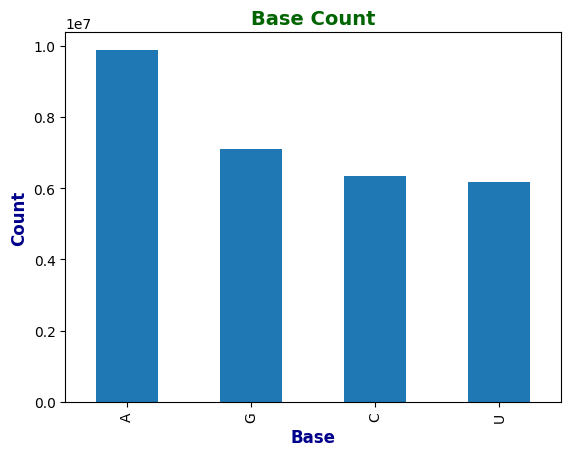

In [54]:
base_dms.plot.bar()
plt.xlabel('Base', fontsize = 12, fontweight = 'bold', color = 'darkblue')
plt.ylabel('Count', fontsize = 12, fontweight = 'bold', color = 'darkblue')
plt.title('Base Count', fontsize = 14, fontweight = 'bold', color = 'darkgreen')

In [55]:
seq_len= opt_train.sequence.apply(len)
seq_len = seq_len.value_counts()
# seq_len = pd.Series(seq_len)
seq_len

sequence
177    294788
170     27254
115      5154
206      4768
155      3652
Name: count, dtype: int64

Text(0.5, 1.0, 'Sequence lenght Distribution')

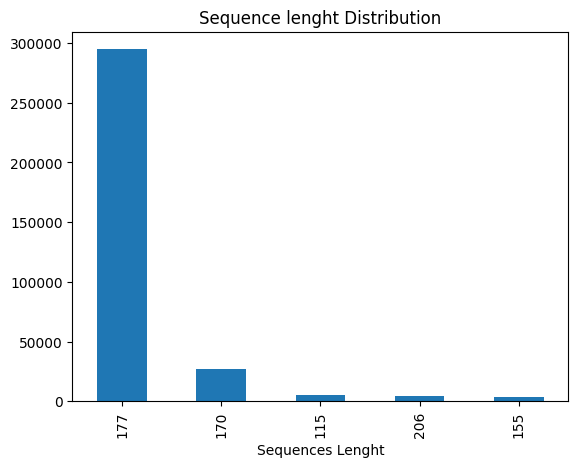

In [56]:
seq_len.plot.bar()
plt.xlabel("Sequences Lenght")
plt.title("Sequence lenght Distribution")

In [57]:
# (opt_train.sequence.apply(lambda x: pd.Series(list(x)).value_counts())).plot.hist()

# Enrich Dataset 
Uisng just the sequence of the training column won't suffice, so to enrich dataset I will be using the:
- [Bpp Files](https://www.kaggle.com/code/umar47/rna-folding-reduce-memory-add-features-seq2seq?scriptVersionId=147271807) - Thanks to [UMAR IGAN](https://www.kaggle.com/umar47) for the code I used to get the Bpp File and their Probability.
<!-- - 3D Coords -->
<!-- - Sequence lib -->
<!-- - OpenKnot metadata -->

to get features for to enrich the dataset.

## BPP features

In [8]:

bpp_file = '/kaggle/input/stanford-ribonanza-rna-folding/Ribonanza_bpp_files/extra_data'
file_paths = []
for folder, _, files in tq(os.walk(bpp_file), total=len(os.listdir(bpp_file))):
    for file in files:
        file_paths.append(os.path.join(folder, file))

4369it [14:14,  5.11it/s]                      


In [9]:
# Get unique sequence_id values from both dataframes
unique_sequence_ids = set(opt_train['sequence_id']) | set(opt_test['sequence_id'])

# Convert file_paths to a set for faster lookup
file_paths_set = set(file_paths)

# Function to filter file paths
def filter_file_path(filepath):
    return os.path.splitext(os.path.basename(filepath))[0] in unique_sequence_ids

# Initialize tqdm with the total number of file paths
with ThreadPoolExecutor() as executor, tq(total=len(file_paths_set), desc="Filtering Files") as pbar:
    # Filter file paths using parallel processing
    filtered_file_paths = list(filter(filter_file_path, file_paths_set))
    pbar.update(len(filtered_file_paths))  # Update the progress bar to completion

Filtering Files:  72%|███████▏  | 1541459/2150396 [00:05<00:02, 289884.50it/s]


In [ ]:
# Create a defaultdict to store sequence_id and their corresponding probabilities
sequence_probabilities = defaultdict(list)

# Initialize tqdm with the list of text files
with tq(total=len(filtered_file_paths), desc="Processing Files") as pbar:
    # Iterate through each file path
    for filepath in filtered_file_paths:
        with open(filepath, "r") as file:
            for line in file:
                # Split each line into values
                values = line.strip().split()  # Split based on spaces

                # Ensure that there are at least 3 values (pair1, pair2, probability)
                if len(values) < 3:
                    continue

                # Extract pair1, pair2, and probability
                _, _, probability = values[:3]

                # Use the filename (without extension) as the key
                sequence_id = os.path.splitext(os.path.basename(filepath))[0]

                # Append the probability to the list for the sequence_id
                sequence_probabilities[sequence_id].append(float(probability))

        pbar.update(1)  # Update the progress bar

# Calculate the average probability for each sequence_id
average_probabilities = {}
for sequence_id, probabilities in sequence_probabilities.items():
    average_prob = sum(probabilities) / len(probabilities)
    average_probabilities[sequence_id] = average_prob

Processing Files:  21%|██        | 319325/1541459 [1:57:24<100347:41:39, 295.59s/it]

In [ ]:
del train
del test
del file_paths
del filtered_file_paths
del sequence_probabilities

In [ ]:
avg_p = pd.DataFrame(average_probabilities, index=[0]).T.reset_index()
avg_p.columns = ['sequence_id', 'avg_probability']
opt_train_new  = opt_train.merge(avg_p, on='sequence_id', how='left').dropna(axis=1,how='all')
opt_test_new  = opt_test.merge(avg_p, on='sequence_id', how='left').dropna(axis=1,how='all')

In [ ]:
exp_dms= opt_train.loc[opt_train.experiment_type == "DMS_MaP"]
exp_2a3= opt_train.loc[opt_train.experiment_type == "2A3_MaP"]

In [ ]:
del opt_train
del opt_test
del average_probabilities
del avg_p

In [ ]:
exp_dms.head()